## Imports

In [1]:
import functools
import os

from clu import metric_writers
import numpy as np
import jax
import matplotlib.pyplot as plt
import optax
import orbax.checkpoint as ocp

import h5py
import natsort
import tensorflow as tf
from scipy.ndimage import geometric_transform
from scipy.ndimage import gaussian_filter

2024-03-11 12:15:18.047970: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
%cd ..

/grad/bzhang388/pisp/DeterministicModels


/grad/bzhang388/anaconda3/envs/jaxflax/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
from src import models
from src import trainers
import SwitchNetModel
from swirl_dynamics import templates
from swirl_dynamics.lib import metrics
from pysteps.utils.spectral import rapsd

Pysteps configuration file found at: /grad/bzhang388/anaconda3/envs/jaxflax/lib/python3.10/site-packages/pysteps/pystepsrc



In [4]:
jax.devices()

[cuda(id=0), cuda(id=1)]

### Dataset

In [5]:
# Parameters for the computational task.

L = 4 # number of levels (even number)
s = 5 # leaf size
r = 3 # rank

# Discretization of Omega (n_eta * n_eta).
neta = (2**L)*s

# Number of sources/detectors (n_sc).
# Discretization of the domain of alpha in polar coordinates (n_theta * n_rho).
# For simplicity, these values are set equal (n_sc = n_theta = n_rho), facilitating computation.
nx = (2**L)*s

# Standard deviation for the Gaussian blur.
blur_sigma = 0.5

# Batch size.
batch_size = 16

# Number of training datapoints.
NTRAIN = 20000

# Number of testing datapoints.
NTEST = 512

# Total number
NTOTAL = NTRAIN + NTEST

In [6]:
tf.config.set_visible_devices([], device_type='GPU')

name = '../data/tri3h'

# Loading and preprocessing perturbation data (eta)
with h5py.File(f'{name}/eta.h5', 'r') as f:
    # Read eta data, apply Gaussian blur, and reshape
    eta_re = f[list(f.keys())[0]][:NTRAIN, :].reshape(-1, neta, neta)
    blur_fn = lambda x: gaussian_filter(x, sigma=blur_sigma)
    eta_re = np.stack([blur_fn(eta_re[i, :, :]) for i in range(NTRAIN)]).astype('float32')

# Loading and preprocessing scatter data (Lambda)
with h5py.File(f'{name}/scatter.h5', 'r') as f:
    keys = natsort.natsorted(f.keys())

    # Process real part of scatter data
    tmp1 = f[keys[3]][:NTRAIN, :]
    tmp2 = f[keys[4]][:NTRAIN, :]
    tmp3 = f[keys[5]][:NTRAIN, :]
    scatter_re = np.stack((tmp1, tmp2, tmp3), axis=-1)

    # Process imaginary part of scatter data
    tmp1 = f[keys[0]][:NTRAIN, :]
    tmp2 = f[keys[1]][:NTRAIN, :]
    tmp3 = f[keys[2]][:NTRAIN, :]
    scatter_im = np.stack((tmp1, tmp2, tmp3), axis=-1)
    
    # Combine real and imaginary parts
    scatter = np.stack((scatter_re, scatter_im), axis=1).astype('float32')
    
# Clean up temporary variables to free memory
del scatter_re, scatter_im, tmp1, tmp2, tmp3

scatter = np.transpose(scatter, (0, 2, 1, 3))
scatter = np.reshape(scatter,(-1, nx, nx, 2, 3))

In [7]:
dict_data = {"eta": eta_re}
dict_data["scatter"] = scatter
dataset = tf.data.Dataset.from_tensor_slices(dict_data)
dataset = dataset.repeat()
dataset = dataset.shuffle(buffer_size=500)
dataset = dataset.batch(batch_size)
dataset = dataset.prefetch(tf.data.AUTOTUNE)
dataset = eval_dataloader = dataset.as_numpy_iterator()

### Architecture

In [8]:
L1 = nx
L2x = nx
L2y = nx
Nw1 = 20
Nb1 = L1 // Nw1
Nw2x = 10
Nw2y = 10
Nb2x = L2x // Nw2x
Nb2y = L2y // Nw2y
r = 3  # rank 


In [9]:
core_module = SwitchNetModel.SwitchNet(
    L1=L1, L2x=L2x, L2y=L2y, Nw1=Nw1, Nb1=Nb1, 
    Nw2x=Nw2x, Nw2y=Nw2y, Nb2x=Nb2x, Nb2y=Nb2y, 
    r=r, NUM_CNN=4
)

In [10]:
Model = models.DeterministicModel(
    input_shape = scatter[0].shape,
    core_module = core_module
)

In [11]:
rng = jax.random.PRNGKey(888)
params = Model.initialize(rng)
param_count = sum(x.size for x in jax.tree_util.tree_leaves(params))
print('Number of trainable parameters:', param_count)

Number of trainable parameters: 9398936


### Training

In [12]:
num_train_steps = 50000  #@param
switchnet_workdir = os.path.abspath('') + "/tmp/SwitchNet3htri"  #@param
initial_lr = 0.0  #@param
peak_lr = 5e-3  #@param
warmup_steps = 500  #@param
end_lr = 1e-5  #@param
ckpt_interval = 2000  #@param
max_ckpt_to_keep = 5  #@param

In [13]:
trainer = trainers.DeterministicTrainer(
    model=Model, 
    rng=jax.random.PRNGKey(42), 
    optimizer=optax.adam(
        learning_rate=optax.warmup_cosine_decay_schedule(
            init_value=initial_lr,
            peak_value=peak_lr,
            warmup_steps=warmup_steps,
            decay_steps=num_train_steps,
            end_value=end_lr,
        ),
    ),
)
     

In [14]:
templates.run_train(
    train_dataloader=dataset,
    trainer=trainer,
    workdir=switchnet_workdir,
    total_train_steps=num_train_steps,
    metric_writer=metric_writers.create_default_writer(
        switchnet_workdir, asynchronous=False
    ),
    metric_aggregation_steps = 100,
    eval_dataloader=eval_dataloader,
    eval_every_steps = 5000,
    num_batches_per_eval = 2,
    callbacks=(
        templates.TqdmProgressBar(
            total_train_steps=num_train_steps,
            train_monitors=("train_loss",),
            eval_monitors=("eval_rrmse_mean",),
        ),
        templates.TrainStateCheckpoint(
            base_dir=switchnet_workdir,
            options=ocp.CheckpointManagerOptions(
                save_interval_steps=ckpt_interval, max_to_keep=max_ckpt_to_keep
            ),
        ),
    ),
)

  0%|          | 0/50000 [00:00<?, ?step/s]

### Inference

In [21]:
trained_state = trainers.TrainState.restore_from_orbax_ckpt(
    f"{switchnet_workdir}/checkpoints", step=None
)

FileNotFoundError: Checkpoint at /grad/bzhang388/pisp/DeterministicModels/tmp/SwitchNet3htri/checkpoints/None not found.

In [40]:
inference_fn = trainers.DeterministicTrainer.build_inference_fn(
    trained_state, core_module
)

In [41]:
# Loading and preprocessing perturbation data (eta)
with h5py.File(f'{name}/eta.h5', 'r') as f:
    # Read eta data, apply Gaussian blur, and reshape
    eta_re = f[list(f.keys())[0]][NTRAIN:NTOTAL, :].reshape(-1, neta, neta)
    blur_fn = lambda x: gaussian_filter(x, sigma=blur_sigma)
    eta_test = np.stack([blur_fn(eta_re[i, :, :]) for i in range(NTEST)]).astype('float32')

# Loading and preprocessing scatter data (Lambda)
with h5py.File(f'{name}/scatter.h5', 'r') as f:
    keys = natsort.natsorted(f.keys())

    # Process real part of scatter data
    tmp1 = f[keys[3]][NTRAIN:NTOTAL, :]
    tmp2 = f[keys[4]][NTRAIN:NTOTAL, :]
    tmp3 = f[keys[5]][NTRAIN:NTOTAL, :]
    scatter_re = np.stack((tmp1, tmp2, tmp3), axis=-1)

    # Process imaginary part of scatter data
    tmp1 = f[keys[0]][NTRAIN:NTOTAL, :]
    tmp2 = f[keys[1]][NTRAIN:NTOTAL, :]
    tmp3 = f[keys[2]][NTRAIN:NTOTAL, :]
    scatter_im = np.stack((tmp1, tmp2, tmp3), axis=-1)
    
    # Combine real and imaginary parts
    scatter_test = np.stack((scatter_re, scatter_im), axis=1).astype('float32')
    
# Clean up temporary variables to free memory
del scatter_re, scatter_im, tmp1, tmp2, tmp3

scatter_test = np.transpose(scatter_test, (0, 2, 1, 3))
scatter_test = np.reshape(scatter_test,(-1, nx, nx, 2, 3))

In [42]:
test_dataset = tf.data.Dataset.from_tensor_slices((scatter_test, eta_test))
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)
test_dataset = eval_dataloader = test_dataset.as_numpy_iterator()

In [43]:
validation_errors_rrmse = [] 
validation_errors_rapsd = [] 

rrmse = functools.partial(
        metrics.mean_squared_error,
        sum_axes=(-1, -2),
        relative=True,
        squared=False,
    )

for batch in test_dataset:
    pred = inference_fn(batch[0])
    true = batch[1]
    validation_errors_rrmse.append(rrmse(pred=pred, true=true))
    for i in range(batch_size):
        validation_errors_rapsd.append(np.abs(np.log(rapsd(pred[i],fft_method=np.fft)/rapsd(true[i],fft_method=np.fft))))

print('relative root-mean-square error = %.3f' % (np.mean(validation_errors_rrmse)*100), '%') 
print('radially averaged power spectrum = %.3f' % np.mean(validation_errors_rapsd)) 

relative root-mean-square error = 21.684 %
radially averaged power spectrum = 0.475


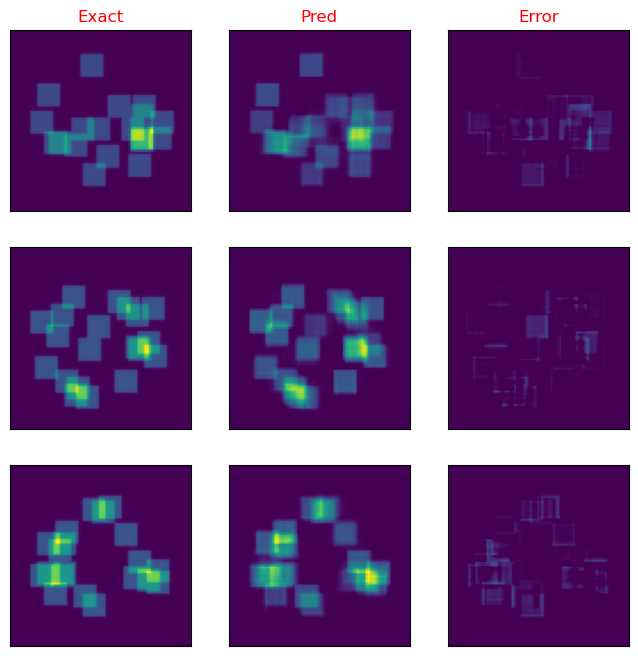

In [44]:
fig = plt.figure(figsize=(8,8))
NPLOT = 3
for kk in range(NPLOT):
    plt.subplot(NPLOT, 3, kk*NPLOT + 1)
    plt.imshow(batch[1][kk,:,:].T)
    plt.xticks([]); plt.yticks([]); clim = plt.gci().get_clim();
    if kk == 0:
        plt.title('Exact', color='red')

    plt.subplot(NPLOT, 3, kk*NPLOT + 2)
    plt.imshow(pred[kk,:,:].T)
    plt.xticks([]); plt.yticks([]); plt.gci().set_clim(clim);
    if kk == 0:
        plt.title('Pred', color='red')

    plt.subplot(NPLOT, 3, kk*NPLOT + 3)
    plt.imshow(batch[1][kk,:,:].T-pred[kk,:,:].T)
    plt.xticks([]); plt.yticks([]); plt.gci().set_clim(clim);
    if kk == 0:
        plt.title('Error', color='red')                
plt.show()
fig.savefig('switchnet.png')